In [136]:
%matplotlib notebook 
from __future__ import division, print_function
import pickle
#import tbxtools.repr
import math
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import cPickle as pickle
import itertools
from dxtbx.model.experiment_list import ExperimentListFactory
from tqdm import tqdm_notebook
from mpl_toolkits.mplot3d import Axes3D
import tbxtools.repr
from sklearn.cluster import DBSCAN

Load the strong reflections to generate summaries of all images

In [171]:
strong_reflections_file = "larger/strong.pickle"
experiments_file = "larger/combined_experiments.json"
indexed_reflections_file = "larger/combined_reflections.pickle"

strong_refs = pickle.load(open(strong_reflections_file))
# print(repr(refs))
spots = [int(math.floor(x["xyzobs.px.value"][2])) for x in strong_refs]
counts = Counter(spots)
max_counts = max(counts.values())
print("Found spots in {} images".format(len(counts)))
print("Largest number of spots found:", max_counts, "in image(s)", [x for x,v in counts.items() if v == max_counts])
print("Image numbers of top 10 counts:", sorted([x[0] for x in list(reversed(sorted([(x, y) for (x, y) in counts.items()], key=lambda x: x[1])))[:10]]))


Found spots in 12800 images
Largest number of spots found: 595 in image(s) [10972]
Image numbers of top 10 counts: [623, 3020, 5278, 7537, 10732, 10817, 10972, 11573, 11575, 11776]


Load the experiments and the indexed reflections file

In [172]:
experiments = ExperimentListFactory.from_json_file(experiments_file, check_format=False)
with open(indexed_reflections_file) as f:
    ref = pickle.load(f)
# Validate that all imagesets are the same, then explicitly set them to be so
assert all(x == experiments.imagesets()[0] for x in experiments.imagesets())
for e in experiments[1:]:
    e.imageset = experiments[0].imageset
print("Loaded {} experiments".format(len(experiments)))
print(repr(ref))

Loaded 2450 experiments
<reflection_table
    bbox                   = <dials_array_family_flex_ext.int6 object at 0x132e69dd0>
    entering               = bool([False, False, False, ..., False, False, False])
    flags                  = size_t([131108,     44,     44, ..., 131108, 131108,     36])
    id                     = int([   0,    0,    0, ..., 2449, 2449, 2449])
    imageset_id            = int([0, 0, 0, ..., 0, 0, 0])
    intensity.sum.value    = double([ 1231.,    38.,   106., ...,    31.,    52.,    48.])
    intensity.sum.variance = double([ 1231.,    38.,   106., ...,    31.,    52.,    48.])
    miller_index           = miller_index([(-20, -20,  14), (-16, -18,  -4), (-16, -18,  13), ......
    n_signal               = int([8, 5, 5, ..., 3, 4, 5])
    panel                  = size_t([0, 0, 0, ..., 0, 0, 0])
    rlp                    = vec3_double([(-0.26017137781790395, 0.5224850671893867, 0.1808361260...
    s1                     = vec3_double([(-0.260171377817903

Match experiments to image number so that we can work out spot-count <-> lattices

In [173]:
image_experiments = defaultdict(list)
for i, exp in enumerate(experiments):
    image = ref.select(ref["id"] == i)["bbox"].parts()[4]
    assert(len(set(image)) == 1)

    image_experiments[image[0]].append(exp)
max_lattices = max(len(x) for x in image_experiments.values())

# Find the top images with no indexing solutions, for diagnostics
unindexed = list(reversed(sorted([x for x in range(len(counts)) if not image_experiments[x]], key=lambda x: counts[x])))
print("Top 10 images with no indexing solution:")
for x, c, name in [(x, counts[x], experiments[0].imageset.paths()[x]) for x in unindexed[:10]]:
    print("[{:6}] {:3} spots {}".format(x, c, name))

Top 10 images with no indexing solution:
[ 10817] 545 spots /dls/i24/data/2018/nt14493-94/pmfuta/limahl1234/limahl0029_80170.cbf
[ 11776] 467 spots /dls/i24/data/2018/nt14493-94/pmfuta/limahl1234/limahl0029_89760.cbf
[  1502] 467 spots /dls/i24/data/2018/nt14493-94/pmfuta/limahl1234/limahl0029_104560.cbf
[  7693] 463 spots /dls/i24/data/2018/nt14493-94/pmfuta/limahl1234/limahl0029_48930.cbf
[ 11049] 456 spots /dls/i24/data/2018/nt14493-94/pmfuta/limahl1234/limahl0029_82490.cbf
[ 11579] 442 spots /dls/i24/data/2018/nt14493-94/pmfuta/limahl1234/limahl0029_87790.cbf
[ 10602] 441 spots /dls/i24/data/2018/nt14493-94/pmfuta/limahl1234/limahl0029_78020.cbf
[ 10877] 434 spots /dls/i24/data/2018/nt14493-94/pmfuta/limahl1234/limahl0029_80770.cbf
[  1508] 419 spots /dls/i24/data/2018/nt14493-94/pmfuta/limahl1234/limahl0029_104610.cbf
[ 10941] 416 spots /dls/i24/data/2018/nt14493-94/pmfuta/limahl1234/limahl0029_81410.cbf


Now draw a graph showing a summary of the lattice finding information

<IPython.core.display.Javascript object>


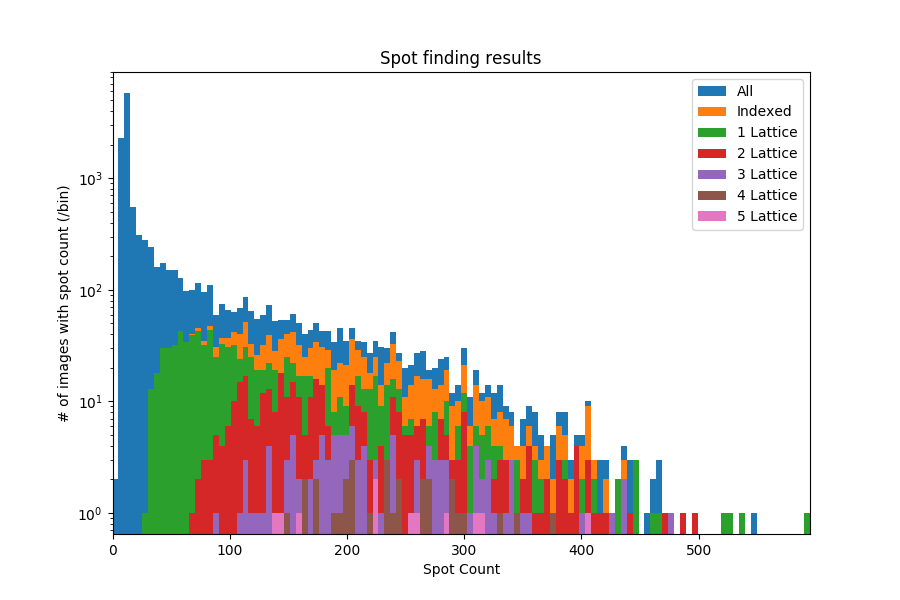

In [174]:
max_hist = int(math.ceil(max_counts/5))*5
bins = np.linspace(0, max_hist, max_hist//5)

plt.figure(figsize=(9,6))
plt.hist(counts.values(), bins=bins, label="All")
# Now draw everything indexed
# indexed_counts = Counter([int(math.floor(x["xyzobs.px.value"][2])) for x in ref])
plt.hist([x for n, x in counts.items() if image_experiments[n]], bins=bins, label="Indexed")
for nlattices in range(1,max_lattices+1):
    # Get counts only for images that have this number of lattices
    vals = [x for n, x in counts.items() if len(image_experiments[n]) == nlattices]
    plt.hist(vals, bins=bins, label="{} Lattice".format(nlattices))
# Plot niceties
plt.yscale("log")
plt.xlim(0, max_hist)
plt.xlabel("Spot Count")
plt.ylabel("# of images with spot count (/bin)")
plt.title("Spot finding results")
plt.legend()
plt.savefig("spotfinding_results.pdf")

Now let's do unit cell distribution stuff

<IPython.core.display.Javascript object>


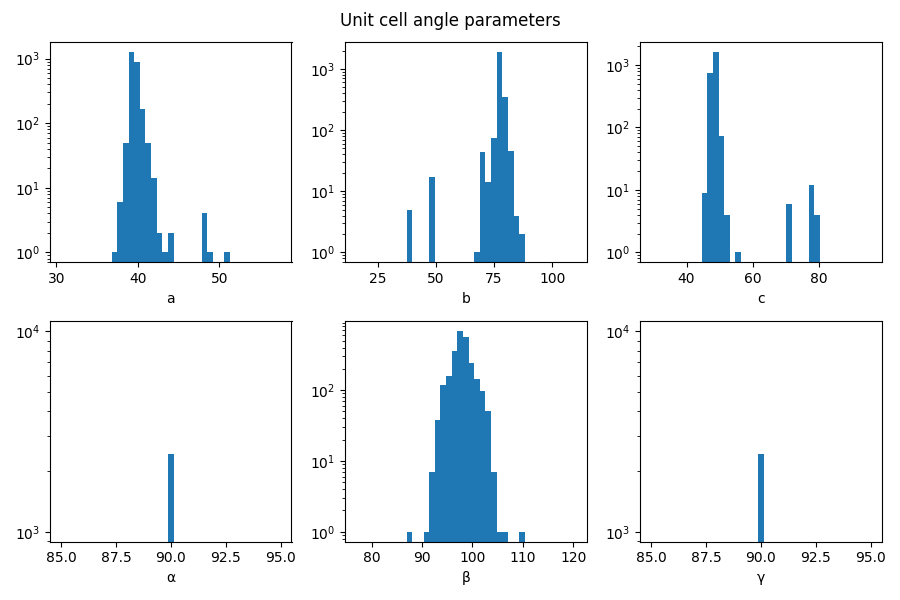

In [175]:
plt.figure(figsize=(9,6))
all_params = [x.get_unit_cell().parameters() for x in experiments.crystals()]
for plot, name in zip(range(6), ["a", "b", "c", u"⍺", u"β", u"γ"]):
    maxval, minval = max(x[plot] for x in all_params), min(x[plot] for x in all_params)
    anglerange = max(5, maxval - minval)
    minr, maxr = (minval+maxval)/2 - anglerange, (minval+maxval)/2 + anglerange
    bins = np.linspace(minr, maxr, 40)
    plt.subplot(2,3,plot+1)
    plt.hist([x[plot] for x in all_params], bins)
    plt.yscale("log")
    plt.xlabel(name)

plt.suptitle("Unit cell angle parameters")
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig("unit_cell_params.pdf")

In [198]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

xs = [x[0] for x in all_params]
ys = [x[1] for x in all_params]
zs = [x[2] for x in all_params]
als = [x[3] for x in all_params]
bes = [x[4] for x in all_params]
gas = [x[5] for x in all_params]

trace1 = go.Scatter3d(
    x=xs,
    y=ys,
    z=zs,
    mode='markers',
    marker=dict(
        size=10,
        opacity=0.5,
    ),
    text=["a: {:.2f}<br>b: {:.2f}<br>c: {:.2f}<br>β: {:.2f}".format(a,b,c,beta) for a,b,c,beta in zip(xs, ys, zs, bes)],
    hoverinfo="text"
)
data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    title='Plot Title',
    scene=dict(
        xaxis=dict(title='a'),
        yaxis=dict(title='b'),
        zaxis=dict(title='c'))
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='simple-3d-scatter')

9 clusters


<IPython.core.display.Javascript object>


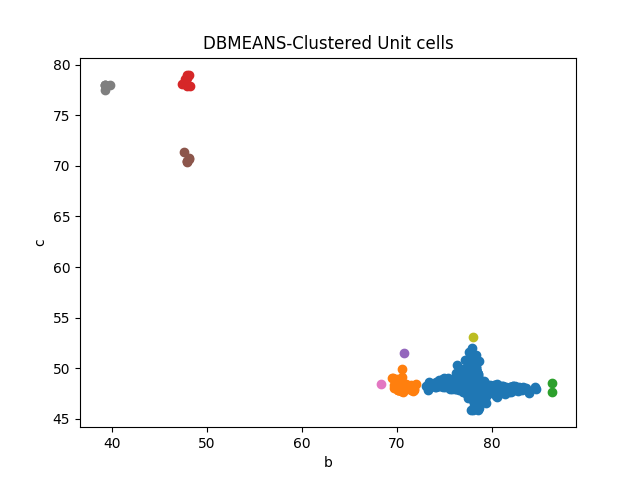

Text(0.5,1,'DBMEANS-Clustered Unit cells')

In [177]:
data_3d = np.array((ys, zs)).T
db = DBSCAN(eps=1, min_samples=1).fit(data_3d)
# db = KMeans(n_clusters=5).fit(data_3d)
labels = db.labels_
from collections import Counter
Counter(labels)
print("{} clusters".format(max(db.labels_)))

fig = plt.figure()
# ax = fig.gca(projection='3d')
for n in range(max(db.labels_)):
    data = np.array([x for i, x in enumerate(data_3d) if db.labels_[i] == n])
    plt.scatter(data[:,0], data[:,1], label=n)
plt.xlabel("b")
plt.ylabel("c")
plt.title("DBMEANS-Clustered Unit cells")

<IPython.core.display.Javascript object>


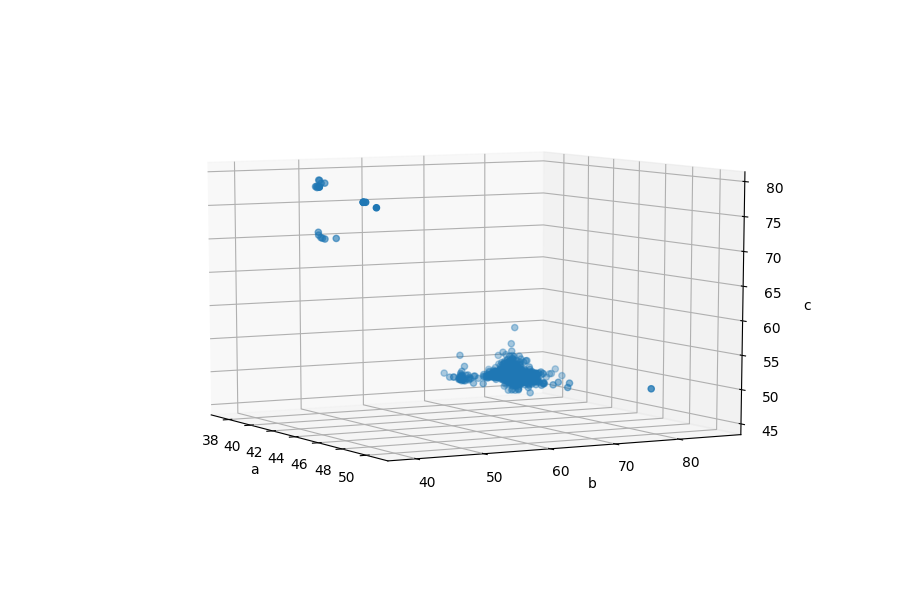

Text(0.5,0,'c')

In [178]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
# xs = [x[0] for x in all_params]
# ys = [x[1] for x in all_params]
# zs = [x[2] for x in all_params]

ax.scatter(xs, ys, zs)
plt.xlabel("a")
plt.ylabel("b")
ax.set_zlabel("c")

<IPython.core.display.Javascript object>


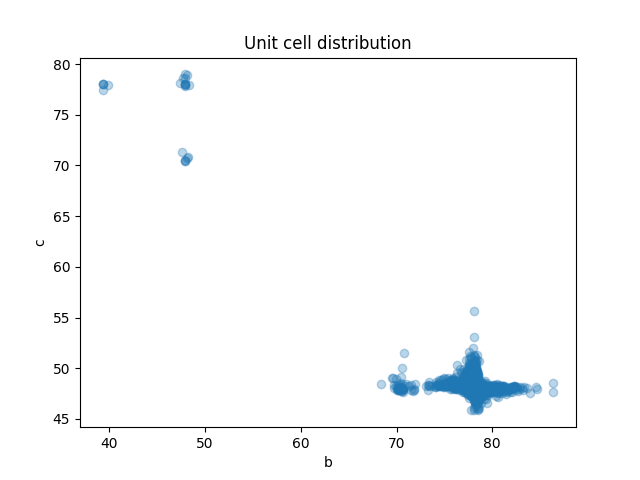

Text(0.5,1,'Unit cell distribution')

In [189]:
# data_3d = np.array((ys, zs)).T
# db = DBSCAN(eps=1, min_samples=1).fit(data_3d)
# # db = KMeans(n_clusters=5).fit(data_3d)
# labels = db.labels_
# from collections import Counter
# Counter(labels)
# print("{} clusters".format(max(db.labels_)))

fig = plt.figure()
# for n in range(max(db.labels_)):
#     data = np.array([x for i, x in enumerate(data_3d) if db.labels_[i] == n])
#     plt.scatter(data[:,0], data[:,1], label=n)
plt.scatter(ys, zs, alpha=0.3)
plt.xlabel("b")
plt.ylabel("c")
plt.title("Unit cell distribution")